In [4]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os

GOAL: how it should look like...

In [5]:
import pickle
pfile = pd.read_pickle(r"/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl")

In [171]:
pfile

,T,S,z,gamma,dTdz,dSdz,lat,lon,log_eps,log_kappa,log_N2_sort,hab,depth,cruise,profile
0,0.594316,34.733891,-3835.0,28.214811,0.002297,0.000235,-25.002001,-38.185333,-10.260384,-5.217481,-5.741873,93.0,-3928.0,1,0
1,0.621936,34.736645,-3825.0,28.212467,0.002297,0.000235,-25.002001,-38.185333,-10.004366,-4.961463,-5.741873,103.0,-3928.0,1,0
2,0.640263,34.738594,-3815.0,28.211014,0.001747,0.000191,-25.002001,-38.185333,-9.833233,-4.638316,-5.893887,113.0,-3928.0,1,0
3,0.656876,34.740475,-3805.0,28.209791,0.001718,0.000172,-25.002001,-38.185333,-10.048473,-4.886051,-5.861392,123.0,-3928.0,1,0
4,0.674622,34.742039,-3795.0,28.208130,0.002518,0.000253,-25.002001,-38.185333,-9.185361,-4.187189,-5.697142,133.0,-3928.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188128,1.588848,34.706534,-2815.0,28.042277,0.000482,-0.000054,-55.144500,-57.980500,-8.865618,-3.598640,-6.403454,160.0,-2975.0,14,170572
188129,1.584602,34.706882,-2825.0,28.043177,0.000509,-0.000039,-55.144500,-57.980500,-8.516571,-3.015310,-6.270092,150.0,-2975.0,14,170572
188130,1.578658,34.707318,-2835.0,28.044395,0.000321,0.000019,-55.144500,-57.980500,-8.574194,-2.781543,-6.177027,140.0,-2975.0,14,170572
188131,1.578185,34.706502,-2845.0,28.043852,0.000007,0.000055,-55.144500,-57.980500,-8.492338,-2.771025,-6.140031,130.0,-2975.0,14,170572


In [7]:
mat_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/arctic_microstructure.mat"
import scipy.io
mat = scipy.io.loadmat(mat_nc)

## each profiler had a two probes. Take mean? See how different they are? take one?

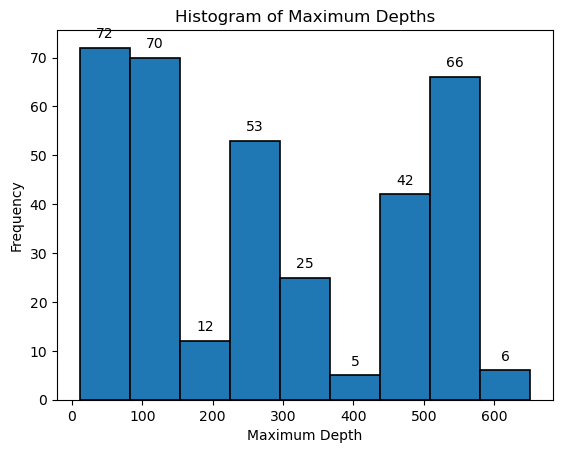

In [251]:
# take the max depth for every profile
max_depths = [max(arr) for arr in depth]

fig, ax = plt.subplots()
n, bins, patches = plt.hist(max_depths, bins=9, edgecolor='black', linewidth=1.2)
# Add labels and title
plt.xlabel('Maximum Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Depths')

# Add text labels to each bin
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.annotate(str(int(y)), xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()

In [452]:
# maintain the 350 profiles
distinct_profiles = mat["vmp"][0,:]

In [180]:
# extract each component in 351,1 shape, so data array for each 
T = np.array([array[10].squeeze() for array in distinct_profiles], dtype=object)
S = np.array([array[11].squeeze()  for array in distinct_profiles], dtype=object)
density = np.array([array[12].squeeze() for array in distinct_profiles], dtype=object)
depth = np.array([array[8].squeeze() for array in distinct_profiles], dtype=object)
N2 = np.array([array[13].squeeze() for array in distinct_profiles], dtype=object)
eps = np.array([array[14].squeeze() for array in distinct_profiles], dtype=object)
k = np.array([array[16].squeeze() for array in distinct_profiles], dtype=object)

In [195]:
length_dict = {i: len(array) for i, array in enumerate(T)}
depth_len = max(length_dict.values())

In [451]:
# repeat longitude dimension for every thing
lon = np.array([array[2].repeat(length_dict[i]).squeeze() for i, array in enumerate(distinct_profiles)], dtype=object)
lat = np.array([array[3].repeat(length_dict[i]).squeeze() for i, array in enumerate(distinct_profiles)], dtype=object)
lon_profiles = np.array([array[2].squeeze() for array in distinct_profiles], dtype=object)
lat_profiles = np.array([array[3].squeeze() for array in distinct_profiles], dtype=object)

# dont know if this is still needed
padded_T = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in T])
padded_S = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in S])
padded_density = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in density])
padded_depth = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in depth])
padded_N2 = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in N2])
padded_eps = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in eps])
padded_k = np.array([np.pad(arr, (0, depth_len - len(arr)), constant_values=np.nan) for arr in k])

## Convert to xr dataset
two dimensions are profile and depth

In [427]:
def fillnan(dataarray):
    for i, array in enumerate(dataarray):
        if (len(array)) < length_dict[i]:
            new_array = np.full((1, length_dict[i]), np.nan)
            dataarray[i] = new_array
    return dataarray

In [435]:
density = fillnan(density)
N2 = fillnan(N2)
eps = fillnan(eps)
k = fillnan(k)

In [436]:
def take_mean(array, depth_array, num, digitized, bin_edges):
    #if len(array[num]) < depth_array:
    #    fillnan(array[num])
    mean = [array[num][digitized == i].mean() for i in range(1, len(bin_edges))]
    return mean

In [443]:
# Create empty dictionary to store DataArrays
data_vars = {}

n = 10 # depth_interval
bin_edges = np.arange(0, n*70, n)

# loop through all arrays and bin them
for num, arr in enumerate(depth):
    digitized = np.digitize(arr, bin_edges)
    # start counting at one so the 0-10 interval fits with the 0m depth
    T_mean= take_mean(T, arr, num, digitized, bin_edges)
    S_mean= take_mean(S, arr, num, digitized, bin_edges)
    
    #density_mean= take_mean(density, arr, num, digitized, bin_edges)
    #N2_mean= take_mean(N2, arr, num, digitized, bin_edges)
    eps_mean = take_mean(eps, arr, num, digitized, bin_edges)
    #k_mean= take_mean(k, arr, num, digitized, bin_edges)
    #data_S = xr.DataArray(S_mean, dims=("depth",), coords={"depth": bin_edges[:-1]})

    # create a new variable for each profile that contains both T and S data
    data_vars[f"profile_{num}"] = xr.Dataset({
        "T": xr.DataArray(T_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        "S": xr.DataArray(S_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"density": xr.DataArray(density_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"N2": xr.DataArray(N2_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        "eps": xr.DataArray(eps_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"k": xr.DataArray(k_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
    })
    
    data_vars[f"profile_{num}"].coords["longitude"] = lon_profiles[num]
    data_vars[f"profile_{num}"].coords["latitude"] = lat_profiles[num]

# Combine all profiles into a single dataset
ds = xr.combine_nested(list(data_vars.values()), concat_dim="profile")

/var/folders/nn/7hvkdmmn3c15btn2lqvyf2800000gq/T/ipykernel_6889/3638461788.py:4: RuntimeWarning: Mean of empty slice.
  mean = [array[num][digitized == i].mean() for i in range(1, len(bin_edges))]
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'depth')

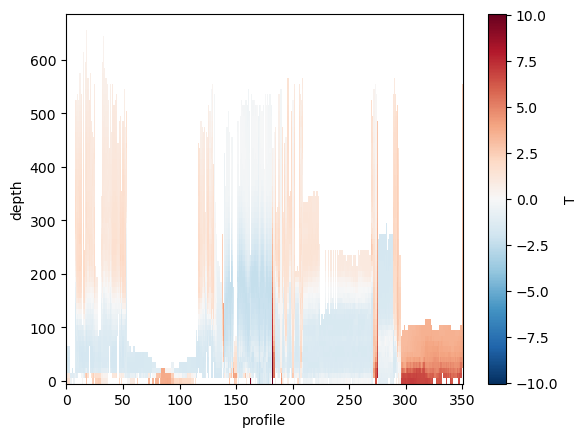

In [448]:
# create a transposed dataset
ds_transposed = ds.transpose("depth", "profile")

# plot the eps variable with transposed coordinates
ds_transposed.T.plot()

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")

Text(0, 0.5, 'depth')

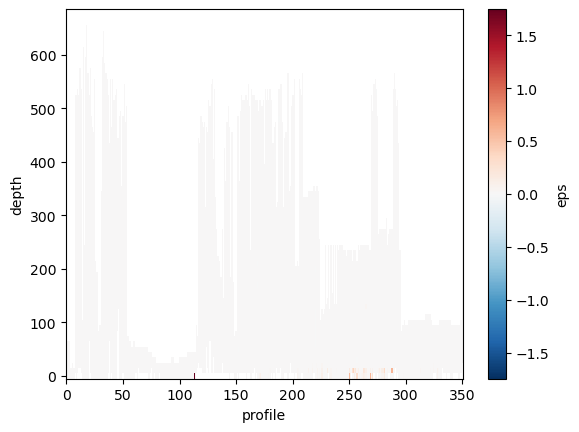

In [447]:
# create a transposed dataset
ds_transposed = ds.transpose("depth", "profile")

# plot the eps variable with transposed coordinates
ds_transposed.eps.plot()

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")

Text(0, 0.5, 'depth')

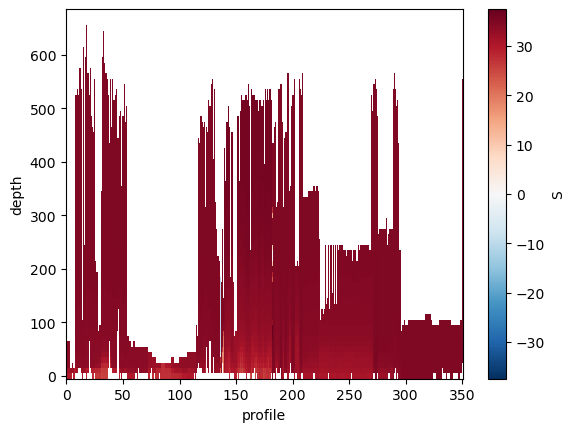

In [449]:
# create a transposed dataset
ds_transposed = ds.transpose("depth", "profile")

# plot the eps variable with transposed coordinates
ds_transposed.S.plot()

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")

# Random plots

# it's not clear whether we should use smoothed N^2 here

#plt.plot(ds2.kappa_sm.mean(axis=0),ds2.z)

#plt.xscale('log')

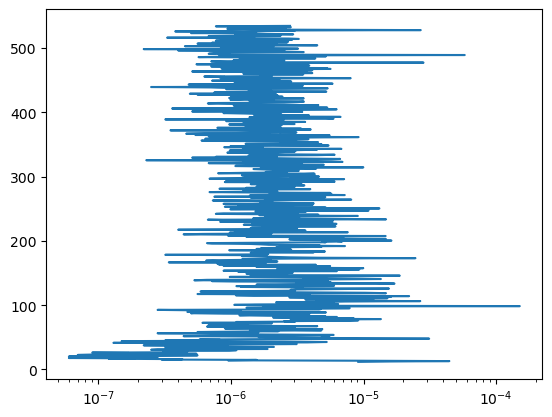

In [60]:
plt.plot(k[10],depth[10])
plt.xscale('log')

In [61]:
profiles = distinct_profiles.shape
profiles

(351,)

In [62]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

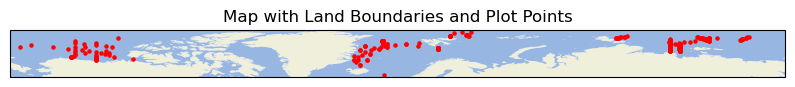

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

In [64]:
# Step 4: Set the map extent, title, and axis ticks
lon_min, lon_max = np.min(lon_profiles), np.max(lon_profiles)
lat_min, lat_max = np.min(lat_profiles), np.max(lat_profiles)
lon_ticks = np.arange(np.floor(lon_min), np.ceil(lon_max), 5)
lat_ticks = np.arange(np.floor(lat_min), np.ceil(lat_max), 5)

Text(0.5, 1.0, 'Map Alberto data for ArcticMix boundaries')

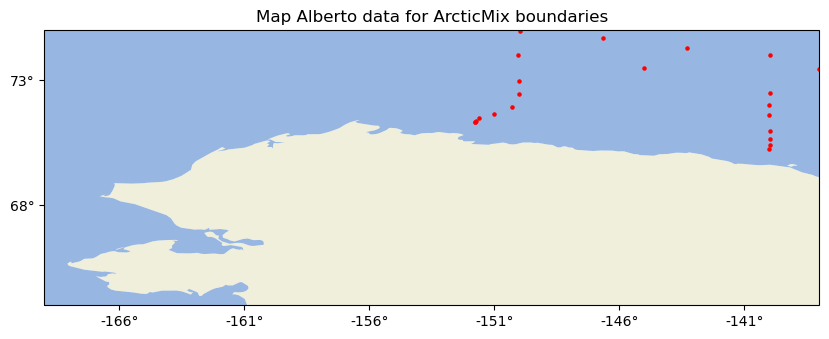

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f"{tick:.0f}°" for tick in lon_ticks])
ax.set_yticklabels([f"{tick:.0f}°" for tick in lat_ticks])

ax.set_extent([-169, -138, 64, 75], crs=ccrs.PlateCarree())
#ax.set_extent([-180, -130, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map Alberto data for ArcticMix boundaries")


#plt.show()